In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join("../")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "pysgmcmc/")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Training model
from models.continual_training_dyn import TrainingDynamics

/home/thobotics/anaconda2/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def f(x):
#     return (np.sin(x + 3) + np.sin(x/2) + 1)
    return (np.sin(2*x + 2.6) + 0.75*np.sin(x))

def generate_data(sample_size = 2000, seed=42,**kwargs):

    rng = np.random.seed(seed)
    
    x = np.random.uniform(low=kwargs["low"], high=kwargs["high"], size=(sample_size))
    y = f(x) # + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

In [4]:
# Generate data
# x_train, y_train = generate_data(5, low=0., high=3.0)
x_train = [0.5, 1.7, 3.8, 4.8, 5.5, 6.5, 7.8]
# x_train = [0.2, 1.0, 2.0, 3.5, 4.8, 5.5, 6.8, 7.8]
y_train = [f(x) for x in x_train]

x_train, y_train = np.array(x_train), np.array(y_train)

x_validate = np.arange(0., 8., 0.01)
y_validate = f(x_validate)

# Convert to matrix
x_train = x_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

x_validate = x_validate[:, np.newaxis]
y_validate = y_validate[:, np.newaxis]

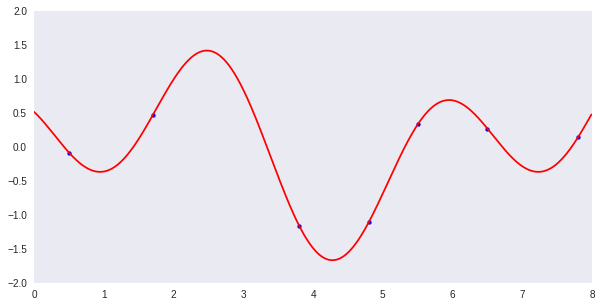

In [5]:
def plot_model(x_tr=None, y_tr=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(x_train, y_train, color = 'blue', s = 15.5)
    
    if x_tr is not None:
        plt.scatter(x_tr, y_tr, color = 'k', s = 1.5)
    
    plt.xlim([-0., 8.])
    plt.ylim([-2., 2.0])

    plt.grid()
    plt.show()
    
plot_model()

In [110]:
dynamics_params = {
    "n_nets": 5,
    "hidden_layers": [
        50,
        50
    ],
#     "nonlinearity": [
#         "tf.nn.relu",
#         "tf.nn.relu"
#     ]
    "nonlinearity": [
        "tf.tanh",
        "tf.tanh"
    ]
}

dynamics_opt_params = {
    "batch_size": 5,
    "scale": 3.0,
    "a0": 1.0,
    "b0": 0.1,
    "a1": 1.0,
    "b1": 5.0,
    "bnn": {
      "run_normal": False,
      "normal_step_size": 1.0e-3,
      "normal_max_iters": 1000,
      "step_size": 4e-3,
      "mdecay": 0.05,
      "burn_in_steps": 10000,
      "max_passes": 100000,
      "sample_steps": 200
    },
    "me": {
      "normal_max_iters": 3000,
      "step_size": 1.0e-3
    },
    "log_every": 5,
    "num_passes_threshold": 25
}

In [111]:
import logging
logger = logging.getLogger()
# logger.setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="BNN", dynamic_params=dynamics_params, dynamic_opt_params=dynamics_opt_params)

DEBUG:root:num_training_dynamics_adam_variables 18


In [112]:
# Add data
u_train = np.array([]).reshape(x_train.shape[0], 0)
training.add_data(x_train, u_train, y_train)

In [113]:
training.run(x_validate, y_validate, params=dynamics_opt_params)

INFO:root:Start sampling
INFO:root:Iter        0 : 
	NLL     = 643.9622192382812 
	NLL_val = 1155.272705078125 
	MSE     = 128.93321228027344 
	MSE_val = 231.26744079589844 
Time =  3.27
INFO:root:Iter      512 : 
	NLL     = 202.54258728027344 
	NLL_val = 459.0514831542969 
	MSE     = 47.66135787963867 
	MSE_val = 107.91443634033203 
Time =  6.23
INFO:root:Iter     1024 : 
	NLL     = 41.89810562133789 
	NLL_val = 269.2895202636719 
	MSE     = 11.801318168640137 
	MSE_val = 75.02893829345703 
Time =  9.20
INFO:root:Iter     1536 : 
	NLL     = 13.639015197753906 
	NLL_val = 181.501220703125 
	MSE     = 4.173469543457031 
	MSE_val = 53.518348693847656 
Time = 12.22
INFO:root:Iter     2048 : 
	NLL     = 6.133495807647705 
	NLL_val = 124.0517349243164 
	MSE     = 2.445899724960327 
	MSE_val = 45.9823112487793 
Time = 15.19
INFO:root:Iter     2560 : 
	NLL     = 2.900245428085327 
	NLL_val = 80.92835235595703 
	MSE     = 1.4934883117675781 
	MSE_val = 36.76814270019531 
Time = 18.15
INFO:root

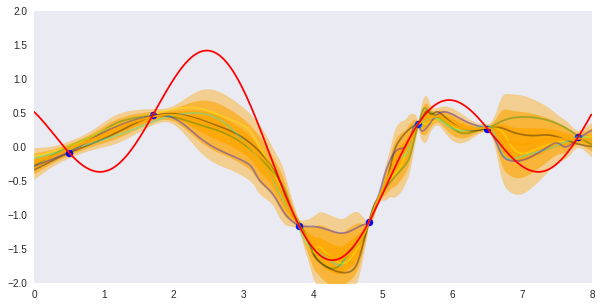

In [114]:
def plot_bnn_model(x_new=None, y_new=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()

    color = ['green', 'k', 'yellow', 'cyan', "blue"]
    
    for i in range(training.model.n_nets):
        y_pred, _ = training.predict(x_validate, return_individual_predictions=True, model_idx=i)
        plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)
    
    mu_pred, var_pred = training.predict(x_validate, return_individual_predictions=False)
    plt.plot(x_validate, mu_pred, "orange", alpha=1.0)
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + np.sqrt(var_pred))[:, 0], 
                     (mu_pred - np.sqrt(var_pred))[:, 0], alpha=0.8, color="orange")
    
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + 2 * np.sqrt(var_pred))[:, 0], 
                     (mu_pred - 2 * np.sqrt(var_pred))[:, 0], alpha=0.6, color="orange")
    
    plt.fill_between(x_validate[:, 0], 
                     (mu_pred + 3 * np.sqrt(var_pred))[:, 0], 
                     (mu_pred - 3 * np.sqrt(var_pred))[:, 0], alpha=0.4, color="orange")
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(training.xu, training.y, color='blue', s=50.5)
    
    if x_new is not None:
        plt.scatter(x_new, y_new, color='black', s=50.5)
    
    # Plot last model
    # y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
    # plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)
    
    plt.xlim([-0., 8.])
    plt.ylim([-2., 2.0])

    plt.grid()
    plt.show()
        
plot_bnn_model()

## Next